MSE for Image 1 at specified time steps:
  Time step 0: MSE = 9.998867608373985e-05
  Time step 10: MSE = 0.0032624714076519012
  Time step 50: MSE = 0.05451454222202301
  Time step 100: MSE = 0.1944376826286316
  Time step 500: MSE = 1.4242843389511108

MSE for Image 2 at specified time steps:
  Time step 0: MSE = 0.00010114492761204019
  Time step 10: MSE = 0.003286519320681691
  Time step 50: MSE = 0.05455932021141052
  Time step 100: MSE = 0.19165438413619995
  Time step 500: MSE = 1.1277074813842773

MSE for Image 3 at specified time steps:
  Time step 0: MSE = 9.963865159079432e-05
  Time step 10: MSE = 0.0033205095678567886
  Time step 50: MSE = 0.05447939410805702
  Time step 100: MSE = 0.19086958467960358
  Time step 500: MSE = 1.1449756622314453

MSE for Image 4 at specified time steps:
  Time step 0: MSE = 0.00010068644769489765
  Time step 10: MSE = 0.003310171887278557
  Time step 50: MSE = 0.05458413437008858
  Time step 100: MSE = 0.19387491047382355
  Time step 500: MSE

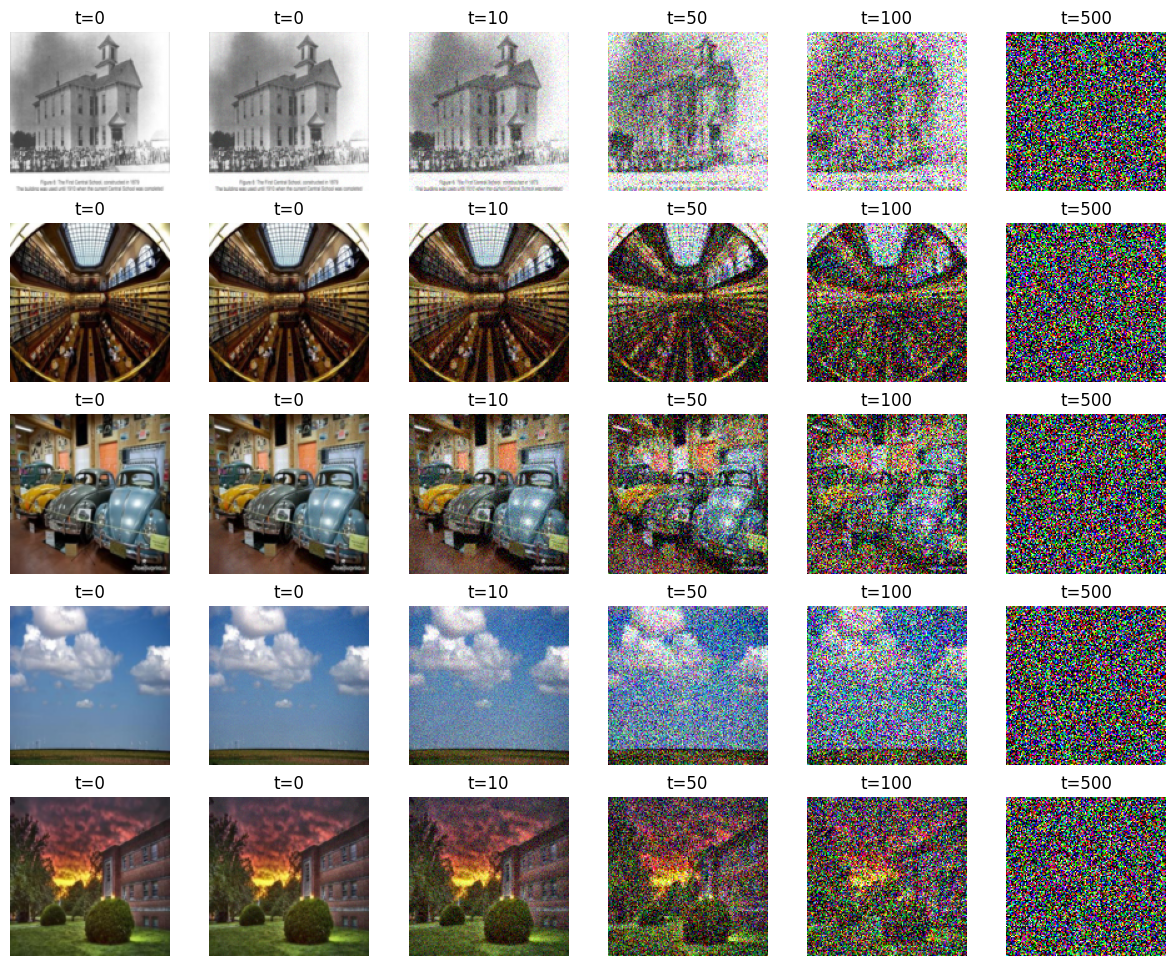

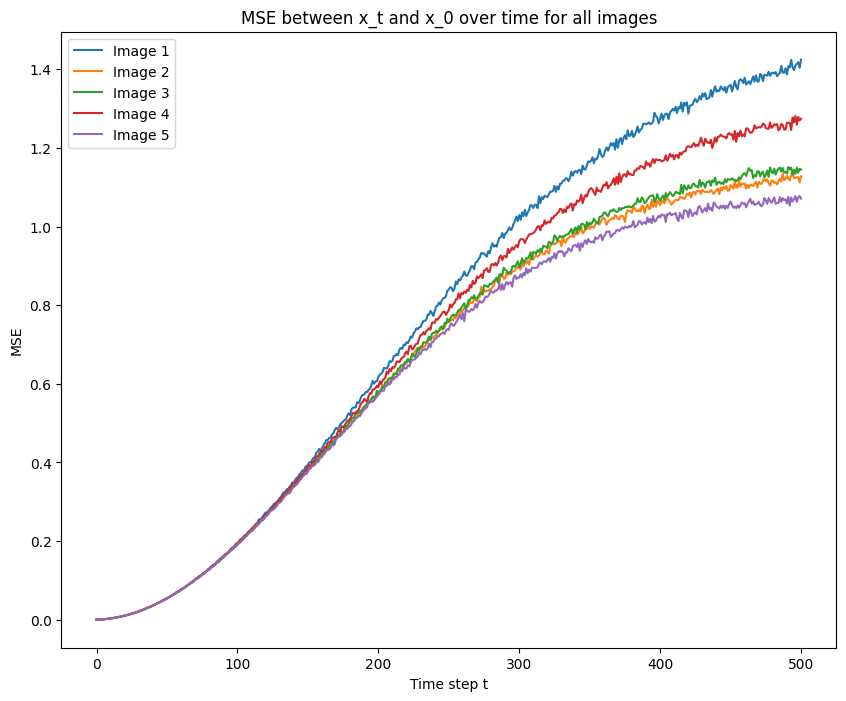

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import glob

torch.manual_seed(0)


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load images from a specified directory
image_dir = './sample_images/'
image_paths = glob.glob(image_dir + '*.jpg')[:5]

images = []
for image_path in image_paths:
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img)
    images.append(img_tensor)


images = torch.stack(images)


T = 501
betas = torch.linspace(1e-4, 0.02, T)


alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)


def forward_diffusion_sample(x0, t):
    """
    Adds Gaussian noise to the original image x0 at time step t.

    Args:
        x0: Original image tensor of shape (batch_size, channels, height, width)
        t: Time step (int)

    Returns:
        x_t: Noisy image at time step t
    """
    sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t]).reshape(1, 1, 1, 1).to(x0.device)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bars[t]).reshape(1, 1, 1, 1).to(x0.device)
    epsilon = torch.randn_like(x0)
    x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t

time_steps_to_plot = [0, 10, 50, 100, 500]
mse_all_images = []


fig, axs = plt.subplots(len(images), len(time_steps_to_plot) + 1, figsize=(15, 12))

for idx, img in enumerate(images):
    x0 = img.unsqueeze(0)

    axs[idx, 0].imshow(np.transpose(x0[0].numpy(), (1, 2, 0)))
    axs[idx, 0].set_title('t=0')
    axs[idx, 0].axis('off')

    mse_list = []

    mse_at_plot_times = {}

    for t in range(T):
        x_t = forward_diffusion_sample(x0, t)
        mse = nn.MSELoss()(x_t, x0).item()
        mse_list.append(mse)


        if t in time_steps_to_plot:
            mse_at_plot_times[t] = mse


            col = time_steps_to_plot.index(t) + 1
            axs[idx, col].imshow(np.clip(np.transpose(x_t[0].numpy(), (1, 2, 0)), 0, 1))
            axs[idx, col].set_title(f't={t}')
            axs[idx, col].axis('off')

    print(f"MSE for Image {idx + 1} at specified time steps:")
    for t in time_steps_to_plot:
        print(f"  Time step {t}: MSE = {mse_at_plot_times[t]}")
    print()

    mse_all_images.append(mse_list)


plt.figure(figsize=(10, 8))
for idx, mse_list in enumerate(mse_all_images):
    plt.plot(range(T), mse_list, label=f'Image {idx + 1}')
plt.xlabel('Time step t')
plt.ylabel('MSE')
plt.title('MSE between x_t and x_0 over time for all images')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

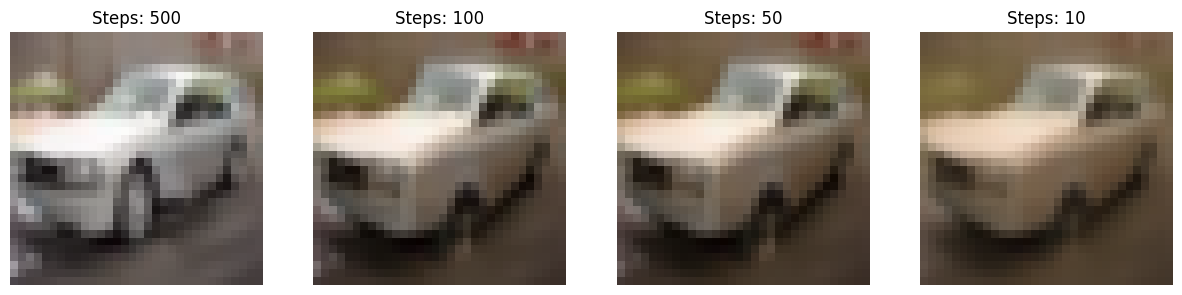

In [ ]:
from diffusers import DDIMPipeline
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"
pipeline = DDIMPipeline.from_pretrained(model_id)
pipeline.to(device)

torch.manual_seed(0)
initial_noise = torch.randn((1, 3, 32, 32), device=device)

sampling_steps_list = [500,100, 50, 10]
generated_images = []

for steps in sampling_steps_list:
    with torch.no_grad():
        result = pipeline(num_inference_steps=steps, generator=torch.Generator(device).manual_seed(0))
        result["sample"] = initial_noise
    image = result.images[0]
    generated_images.append((steps, image))

fig, axs = plt.subplots(1, len(sampling_steps_list), figsize=(15, 5))
for i, (steps, img) in enumerate(generated_images):
    axs[i].imshow(img)
    axs[i].set_title(f'Steps: {steps}')
    axs[i].axis("off")
plt.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

A photo of a man making a pizza


  0%|          | 0/50 [00:00<?, ?it/s]

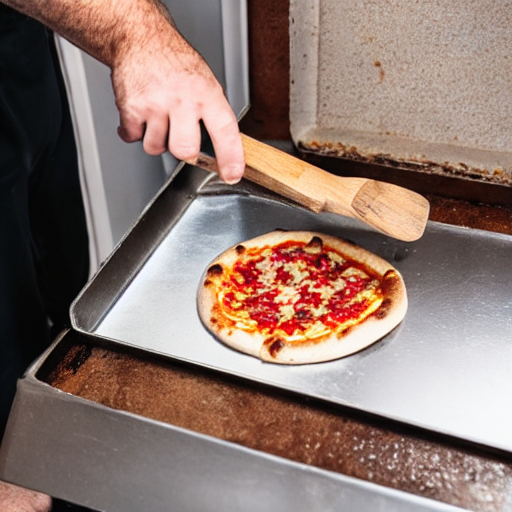

A photo of a man making a steak


  0%|          | 0/50 [00:00<?, ?it/s]

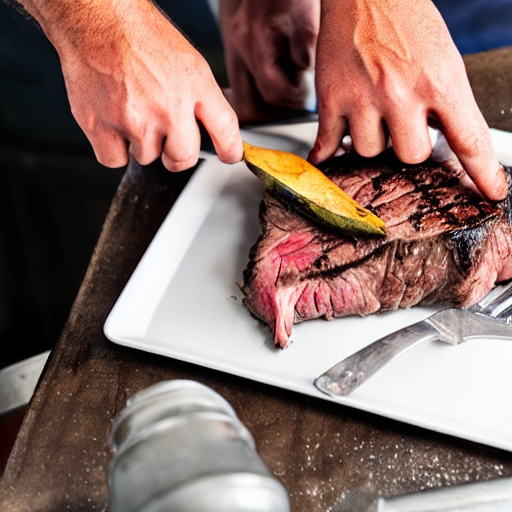

A photo of a man making a (pizza:0.4)


  0%|          | 0/50 [00:00<?, ?it/s]

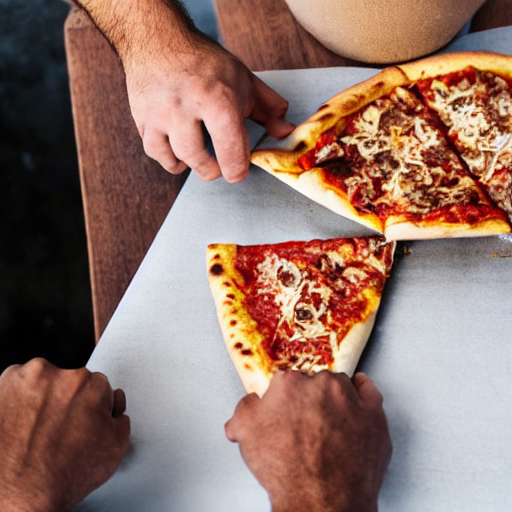

A black and white photo of a man making a pizza


  0%|          | 0/50 [00:00<?, ?it/s]

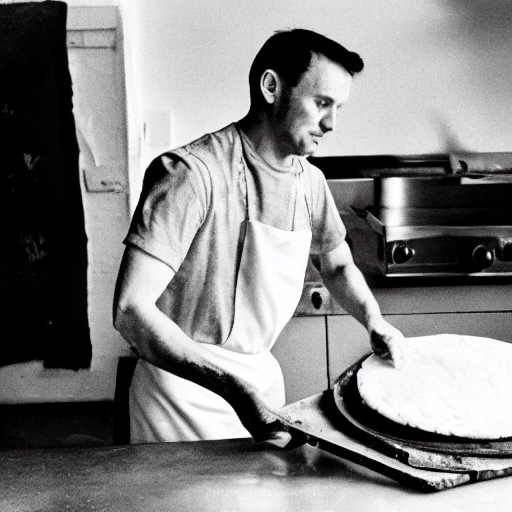

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from IPython.display import display
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler


device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.to(device)

def generate_image(prompt, negative_prompt=None, guidance_scale=7.5, num_inference_steps=50):
    """
    Generate an image using prompt-to-prompt editing.

    Args:
        prompt (str): The input text prompt for generation.
        negative_prompt (str): Optional negative prompt to suppress certain features.
        guidance_scale (float): The scale for classifier-free guidance.
        num_inference_steps (int): Number of diffusion steps to take.
    """
    image = pipe(prompt,
                 negative_prompt=negative_prompt,
                 guidance_scale=guidance_scale,
                 generator=torch.Generator(device).manual_seed(0),
                 num_inference_steps=num_inference_steps).images[0]

    return image


prompts = {
    "original": "A photo of a man making a pizza",
    "replacement": "A photo of a man making a steak",
    "reweight": "A photo of a man making a (pizza:0.4)",
    "refinement": "A black and white photo of a man making a pizza"
}

guidance_scale = 7.5
num_inference_steps = 50


images = {}
for edit_type, prompt in prompts.items():
    print(prompt)
    image = generate_image(prompt, negative_prompt=None, guidance_scale=guidance_scale, num_inference_steps=num_inference_steps)
    display(image)